In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile as z
from PIL import Image
from imblearn.under_sampling import RandomUnderSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import os
from sklearn import preprocessing# label encoding
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = '5'

### Entire Training Dataset

In [2]:
df = pd.read_csv('all_data_info.csv')

In [3]:
print(df.shape)
df.head()

(103250, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [4]:
# number of artists
len(df['artist'].unique())

2319

In [5]:
# missing artist names?
df['artist'].isnull().sum()

0

In [6]:
# num paintings per artist
by_artist = pd.DataFrame(df['artist'].value_counts().reset_index())
by_artist.columns = ['artist','count']
by_artist

,artist,count
0,Ivan Aivazovsky,500
1,John Singer Sargent,500
2,Pierre-Auguste Renoir,500
3,Marc Chagall,500
4,Pablo Picasso,500
...,...,...
2314,Adoration of the Shepherds,1
2315,Dua,1
2316,Transfer Series,1
2317,Portrait of a Woman,1


In [7]:
# number of artists with > 200 paintings
len(by_artist[by_artist['count'] >= 200])

110

In [8]:
# remove data where < 200 paintings per artist
by_artist = by_artist[by_artist['count'] >= 200]

Text(0.5, 0, 'num paintings')

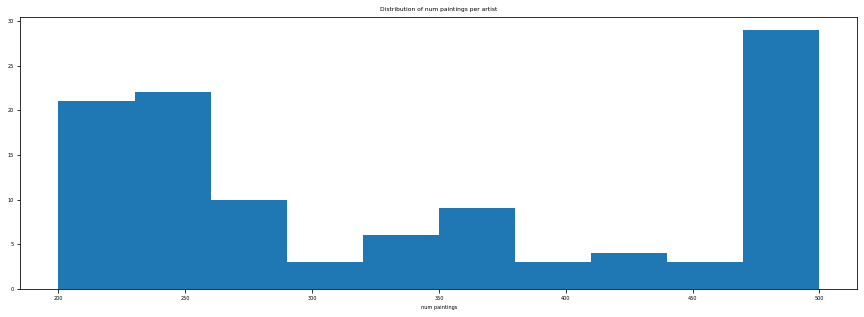

In [9]:
plt.hist(by_artist['count'])
plt.title('Distribution of num paintings per artist')
plt.xlabel('num paintings')

In [10]:
# removing artists from the main df that have < 200 paintings
df_200 = df[df['artist'].isin(by_artist['artist'])]

In [11]:
df_200.shape # 37452 rows

(37452, 12)

In [12]:
df_200['artist'].value_counts()

Ivan Aivazovsky           500
Rembrandt                 500
Zdislav Beksinski         500
Ilya Repin                500
John Singer Sargent       500
                         ... 
Honore Daumier            206
Ilya Mashkov              203
Thomas Lawrence           203
Paul Klee                 200
James McNeill Whistler    200
Name: artist, Length: 110, dtype: int64

### Subset: Train 1 and Train 2

__lines below commented so don't need to create df_sub from scratch each time - just load saved pickle file__

In [13]:
# entire training set to large so downloading subset train 1

# filenames_train1 = []
# with z.ZipFile('train_1.zip', 'r') as zip:
#     for info in zip.infolist():
#         name = info.filename.split('/')
#         filenames_train1.append(name[1])

In [14]:
# entire training set to large so downloading subset train 1

# filenames_train2 = []
# with z.ZipFile('train_2.zip', 'r') as zip:
#     for info in zip.infolist():
#         name = info.filename.split('/')
#         filenames_train2.append(name[1])

In [15]:
# train1_df = df[df['new_filename'].isin(filenames_train1)] 

In [16]:
# train2_df = df[df['new_filename'].isin(filenames_train2)] 

In [17]:
# train1_df.reset_index(inplace=True)

In [18]:
# train2_df.reset_index(inplace=True)

In [19]:
# saving train1_df and train2_df
# train1_df.to_pickle("train1_df.pkl")
# train2_df.to_pickle("train2_df.pkl")

In [20]:
# load train1 and train2 dataframes from pickle file
train1_df = pd.read_pickle("train1_df.pkl")
train2_df = pd.read_pickle("train2_df.pkl")

In [21]:
print(train1_df.shape)
train1_df.head()

(11025, 13)


,index,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,23,Jan van Eyck,1439,religious painting,4000.0,8311.0,28783029.0,wikiart,Northern Renaissance,The Madonna in the Church,train_and_test,True,16876.jpg
2,42,Thomas Gainsborough,1783,landscape,5712.0,4704.0,11791905.0,wikiart,Rococo,The Mall in St. James's Park,train_and_test,True,1164.jpg
3,46,Lyonel Feininger,1926.0,cityscape,4472.0,5894.0,7382419.0,wikiart,Cubism,Gelmeroda IX,train_only,True,19385.jpg
4,74,Henri de Toulouse-Lautrec,1895,genre painting,5833.0,3985.0,3389831.0,wikiart,Post-Impressionism,Abandonment (The pair),train_and_test,True,17354.jpg


In [22]:
print(train2_df.shape)
train2_df.head()

(8476, 13)


,index,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,5,Tosa Mitsuoki,NaN,mythological painting,25528.0,3000.0,10496349.0,wikiart,Yamato-e,Night March of a Hundred Demons (left half),train_only,True,29855.jpg
1,17,Hiroshige,NaN,bird-and-flower painting,4154.0,9051.0,5964682.0,wikiart,Ukiyo-e,Hydrangea and Kingfisher,train_and_test,True,23508.jpg
2,19,Hiroshige,1850,bird-and-flower painting,4045.0,8999.0,5930496.0,wikiart,Ukiyo-e,"Moon, Swallows and Peach Blossoms",train_and_test,True,27254.jpg
3,24,Julius LeBlanc Stewart,1896,genre painting,6980.0,4724.0,2484194.0,wikiart,Realism,Yachting in the Mediterranean,train_only,True,28908.jpg
4,30,Clara Peeters,1612.0,still life,4913.0,6007.0,8684895.0,wikiart,Baroque,Still Life with Flowers and Gold Cups of Honor,train_only,True,28363.jpg


In [23]:
# number of unique artists in train1 and train2
print("train1 num artists: ", len(train1_df['artist'].unique()))
print("train2 num artists: ", len(train2_df['artist'].unique()))

train1 num artists:  1500
train2 num artists:  1437


In [24]:
# combining both tables
df_sub = pd.concat([train1_df,train2_df], ignore_index=True)
print(df_sub.shape)
# drop 'index' col
df_sub.drop('index', axis=1, inplace=True)
df_sub.head()

(19501, 13)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Jan van Eyck,1439,religious painting,4000.0,8311.0,28783029.0,wikiart,Northern Renaissance,The Madonna in the Church,train_and_test,True,16876.jpg
2,Thomas Gainsborough,1783,landscape,5712.0,4704.0,11791905.0,wikiart,Rococo,The Mall in St. James's Park,train_and_test,True,1164.jpg
3,Lyonel Feininger,1926.0,cityscape,4472.0,5894.0,7382419.0,wikiart,Cubism,Gelmeroda IX,train_only,True,19385.jpg
4,Henri de Toulouse-Lautrec,1895,genre painting,5833.0,3985.0,3389831.0,wikiart,Post-Impressionism,Abandonment (The pair),train_and_test,True,17354.jpg


In [25]:
# number of unique artists
len(df_sub['artist'].unique())

1675

In [26]:

#merging train 1 and train 2 folders (unzip them first)
#import os
#import shutil

# #Path of source directory & destination directory
#src_directory = 'train_2'
#dst_directory = 'train_1'

# # Extract file from Source directory and move to Destination directory
#for file in os.listdir(src_directory):
     #src_file = os.path.join(src_directory, file)
     #dest_file = os.path.join(dst_directory, file)
     #shutil.move(src_file, dest_file)

# all should be in 'train_1', compress it for storage renamed as train.zip

merged files in train.zip under train_1 directory

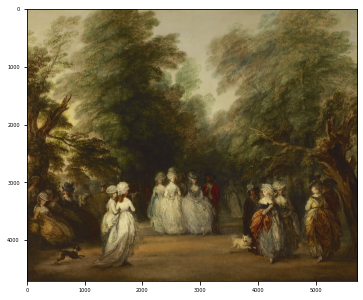

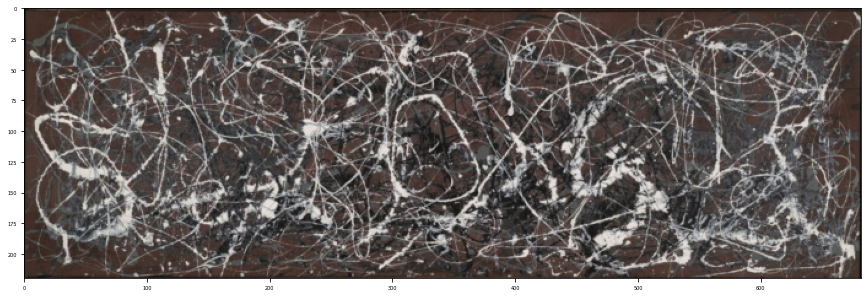

In [27]:
# looking at some images
archive = z.ZipFile('train.zip', 'r')
file = df_sub.loc[2]['new_filename']
imgdata = archive.open('train_1/'+file)
img = Image.open(imgdata)
plt.imshow(img)
plt.show()

file = df_sub.loc[19500]['new_filename']
imgdata = archive.open('train_1/'+file)
img = Image.open(imgdata)
plt.imshow(img)
plt.show()

In [28]:
df_sub['artist'].value_counts().head(10)

Boris Kustodiev          119
Pierre-Auguste Renoir    111
Ilya Repin               105
Claude Monet             103
Pyotr Konchalovsky       102
John Singer Sargent      101
Ivan Aivazovsky          100
Paul Cezanne             100
Odilon Redon              98
Camille Pissarro          97
Name: artist, dtype: int64

__largest number of paintings per artist in df_sub is 119 (compared to 500 in entire training data)__

In [29]:
by_artist_1 = pd.DataFrame(df_sub['artist'].value_counts().reset_index())
by_artist_1.columns = ['artist','count']
by_artist_1

,artist,count
0,Boris Kustodiev,119
1,Pierre-Auguste Renoir,111
2,Ilya Repin,105
3,Claude Monet,103
4,Pyotr Konchalovsky,102
...,...,...
1670,Scene Baptism of Christ,1
1671,Jester,1
1672,the central panel from St. Hippolytus Triptych,1
1673,Fire,1


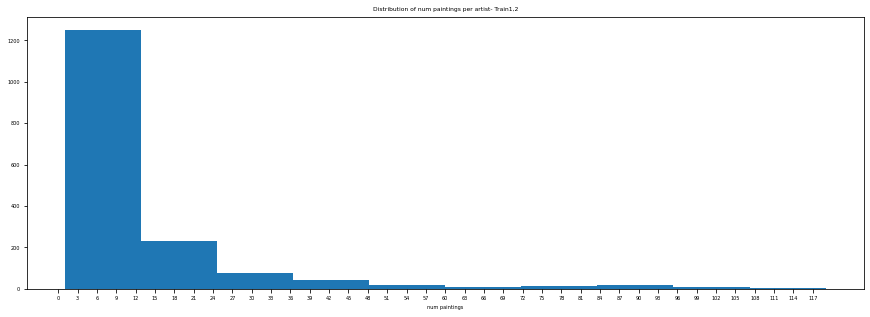

In [30]:
plt.hist(by_artist_1['count'])
plt.title('Distribution of num paintings per artist- Train1,2')
plt.xlabel('num paintings')
plt.xticks(range(0, 119,3))
plt.show()

In [31]:
# number of artists with > 80 paintings
len(by_artist_1[by_artist_1['count'] >= 80])

36

In [32]:
by_artist_1 = by_artist_1[by_artist_1['count'] >= 80]
# removing artists from the main df that have < 80 paintings
df_80 = df_sub[df_sub['artist'].isin(by_artist_1['artist'])]

In [33]:
print(df_80.shape)
print("num artists: ", len(df_80['artist'].unique()))
df_80.head()

(3347, 12)
num artists:  36


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
4,Henri de Toulouse-Lautrec,1895,genre painting,5833.0,3985.0,3389831.0,wikiart,Post-Impressionism,Abandonment (The pair),train_and_test,True,17354.jpg
16,Ernst Ludwig Kirchner,1910,genre painting,4728.0,3528.0,11325985.0,wikiart,Expressionism,Girl with Cat (Franzi),train_and_test,True,101495.jpg
52,Giovanni Battista Piranesi,NaN,cityscape,3893.0,3072.0,3777012.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,True,11889.jpg
61,Giovanni Battista Piranesi,NaN,cityscape,3899.0,2874.0,3882429.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,True,14108.jpg
68,Giovanni Battista Piranesi,NaN,cityscape,3899.0,2732.0,3779034.0,wikipedia,Neoclassicism,Vedute di Roma,train_and_test,True,1155.jpg


__df_80 has data from df_sub with artists having >= 80 paintings (max = 119)__

In [34]:
df_80.groupby('artist').size()

artist
Albrecht Durer                 95
Alfred Sisley                  84
Boris Kustodiev               119
Camille Corot                  94
Camille Pissarro               97
Childe Hassam                  84
Claude Monet                  103
Edgar Degas                    95
Ernst Ludwig Kirchner          83
Eugene Boudin                  95
Fernand Leger                  96
Giovanni Battista Piranesi     92
Gustave Dore                   88
Henri Martin                   81
Henri Matisse                  86
Henri de Toulouse-Lautrec      82
Ilya Repin                    105
Isaac Levitan                  84
Ivan Aivazovsky               100
Ivan Shishkin                  90
James Tissot                   81
John Singer Sargent           101
Marc Chagall                   92
Martiros Saryan                90
Nicholas Roerich               89
Odilon Redon                   98
Pablo Picasso                  92
Paul Cezanne                  100
Paul Gauguin                   97
Pierre-

In [35]:
# balancing the classes (making all artists have 80 paintings)
X = df_80.drop('artist', axis=1)
y = df_80['artist']
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

In [36]:
print(X_rus.shape)
print(36*81)
y_rus.value_counts()

(2916, 11)
2916


Albrecht Durer                81
Alfred Sisley                 81
James Tissot                  81
John Singer Sargent           81
Marc Chagall                  81
Martiros Saryan               81
Nicholas Roerich              81
Odilon Redon                  81
Pablo Picasso                 81
Paul Cezanne                  81
Paul Gauguin                  81
Pierre-Auguste Renoir         81
Pyotr Konchalovsky            81
Rembrandt                     81
Theophile Steinlen            81
Vincent van Gogh              81
Zdislav Beksinski             81
Ivan Shishkin                 81
Ivan Aivazovsky               81
Isaac Levitan                 81
Ernst Ludwig Kirchner         81
Boris Kustodiev               81
Camille Corot                 81
Camille Pissarro              81
Childe Hassam                 81
Claude Monet                  81
Edgar Degas                   81
Eugene Boudin                 81
Ilya Repin                    81
Fernand Leger                 81
Giovanni B

Resampled so dataset is now 36 artists each with 81 paintings

In [37]:
# saving X_rus and y_rus as pickle files
# X_rus.to_pickle("X_rus.pkl")
# y_rus.to_pickle("y_rus.pkl")

In [38]:
# X_rus = pd.read_pickle("X_rus.pkl")
# y_rus = pd.read_pickle("y_rus.pkl")

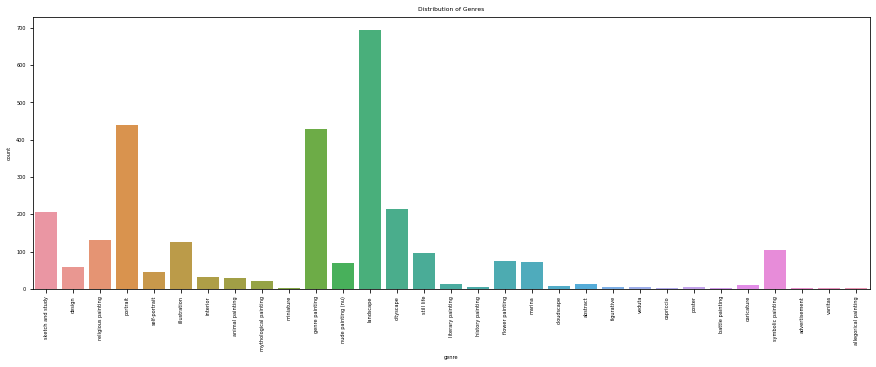

In [39]:
sns.countplot(x='genre', data=X_rus)
plt.xticks(rotation=90)
plt.title('Distribution of Genres')
plt.show()

### Resizing images to 256x256 according to paper. Also normalizing and creating dataloader

In [40]:
# directory = 'train_1'

# for filename in os.listdir(directory):
#     try:
#         if filename.endswith('.jpg'):
#             img_path = os.path.join(directory, filename)
#             with Image.open(img_path) as img:
#                 img_resized = img.resize((256, 256), resample=Image.BILINEAR)
#                 img_resized.convert('RGB').save(os.path.join(directory, filename))
#     except:
#         print(f"Could not process image {filename}")

In [41]:
# remove record of corrupted image file 101947.jpg
X_rus[X_rus['new_filename']=='101947.jpg'] #not included after resampling anyways

,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename


__Images resized to 256x256__

(256, 256)


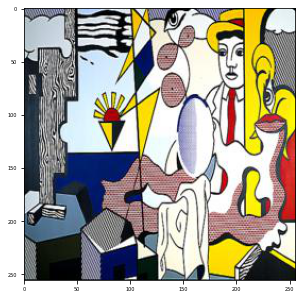

In [42]:
filename = df_sub.loc[19400]['new_filename'] 
img = Image.open(os.path.join('train_1', filename))
plt.imshow(img)
print(img.size)  # Should print (256, 256)

In [43]:
# transforming image - normalization improves performance
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # applying ImageNet normalization
    ])    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


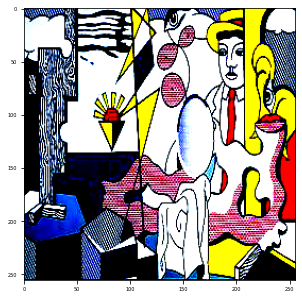

In [44]:
# look at transformed image
filename = df_sub.loc[19400]['new_filename'] 
img = Image.open(os.path.join('train_1', filename))
tr_img = transform(img)
plt.imshow(tr_img.numpy().transpose(1,2,0))
plt.show()

In [45]:
le = preprocessing.LabelEncoder() # one hot encoding instead? but 36 classes
artists = list(y_rus.unique())
le.fit(artists)
le.classes_

array(['Albrecht Durer', 'Alfred Sisley', 'Boris Kustodiev',
       'Camille Corot', 'Camille Pissarro', 'Childe Hassam',
       'Claude Monet', 'Edgar Degas', 'Ernst Ludwig Kirchner',
       'Eugene Boudin', 'Fernand Leger', 'Giovanni Battista Piranesi',
       'Gustave Dore', 'Henri Martin', 'Henri Matisse',
       'Henri de Toulouse-Lautrec', 'Ilya Repin', 'Isaac Levitan',
       'Ivan Aivazovsky', 'Ivan Shishkin', 'James Tissot',
       'John Singer Sargent', 'Marc Chagall', 'Martiros Saryan',
       'Nicholas Roerich', 'Odilon Redon', 'Pablo Picasso',
       'Paul Cezanne', 'Paul Gauguin', 'Pierre-Auguste Renoir',
       'Pyotr Konchalovsky', 'Rembrandt', 'Theophile Steinlen',
       'Vincent van Gogh', 'Zdislav Beksinski', 'Zinaida Serebriakova'],
      dtype='<U26')

In [46]:
l = le.transform(y_rus)
y_rus,l

(0             Albrecht Durer
 1             Albrecht Durer
 2             Albrecht Durer
 3             Albrecht Durer
 4             Albrecht Durer
                 ...         
 2911    Zinaida Serebriakova
 2912    Zinaida Serebriakova
 2913    Zinaida Serebriakova
 2914    Zinaida Serebriakova
 2915    Zinaida Serebriakova
 Name: artist, Length: 2916, dtype: object,
 array([ 0,  0,  0, ..., 35, 35, 35]))

In [47]:
# create dataloaders, batch size etc
class CustomImageDataset(Dataset):
    def __init__(self,img_dir, X,y, transformation): # pass X_rus, y_rus, img_dir='train_1' for training
        self.transformation = transform
        # is encoder needed?
        self.encoder = le
        self.img_dir = img_dir
        self.feats, self.labels = self.get_all(self.img_dir,X,y)
        
    def get_all(self,img_dir,X,y):
        images = []
        labels = []
        
        for index, row in X.iterrows():
            file = row['new_filename']
            img = Image.open(os.path.join(img_dir, file)) 
            data = self.transformation(img)
            images.append(data)
            
            
        labels = self.encoder.transform(y)
        
        
        images = torch.stack(images)
        labels = torch.LongTensor(labels)
        return images, labels
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,item):
        return self.feats[item], self.labels[item]
        

In [48]:
# need to do similar for test data^

In [49]:
#trainset = CustomImageDataset('train_1',X_rus,y_rus,transform)

In [50]:
#torch.save(trainset,"trainset.pt")

In [51]:
# load saved Dataset
trainset = torch.load("trainset.pt")

In [52]:
# split into train and val [80:20]
batch_size= 32
labels = trainset.labels.numpy()
train_indices, val_indices = train_test_split(np.arange(len(labels)),test_size=0.2,
                                              shuffle=True,random_state=42,stratify=labels)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler,drop_last=True)
val_loader = DataLoader(trainset, batch_size=batch_size, sampler=val_sampler,drop_last=True)

### Baseline CNN
Based on: http://cs229.stanford.edu/proj2018/report/41.pdf

In [53]:
num_classes = 36

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

cpu


In [55]:
class CNNBase(nn.Module):
    def __init__(self):
        super(CNNBase,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,16,3,padding=1)
        self.conv3 = nn.Conv2d(16,16,3,padding=1)
        self.conv4 = nn.Conv2d(16,32,3,padding=1)
        self.conv5 = nn.Conv2d(32,128,3,padding=1)
        self.conv6 = nn.Conv2d(128,256,3,padding=1)
        self.relu = nn.ReLU()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(16384,2048)
        self.fc2 = nn.Linear(2048,num_classes)
        self.pool = nn.MaxPool2d(2) 
        #self.softmax = nn.Softmax(dim=1) need to remove during training as cross entropy loss already has softmax
        
    def forward(self,x):
        #print("start: ", x.shape)
        x = self.relu(self.bn16(self.conv1(x)))
        #print("conv1: ", x.shape)
        x = self.pool(self.relu(self.bn16(self.conv2(x))))
        #print("conv2: ", x.shape)
        x = self.pool(self.relu(self.bn16(self.conv3(x))))
        #print("conv3: ", x.shape)
        x = self.pool(self.relu(self.bn32(self.conv4(x))))
        #print("conv4: ", x.shape)
        x = self.pool(self.relu(self.bn128(self.conv5(x))))
        #print("conv5: ", x.shape)
        x = self.pool(self.relu(self.bn256(self.conv6(x))))
        #print("conv6: ", x.shape)
        x = torch.flatten(x, start_dim=1)
        #print("flatten: ", x.shape)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        #print("fc1: ", x.shape)
        x = self.fc2(x)
        #print("fc2: ", x.shape)
        x = self.dropout(x)
        return x


In [56]:
cnn_base = CNNBase()
cnn_base.to(device)

CNNBase(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (bn16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn128): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn256): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, ou

In [57]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(cnn_base.parameters())

In [ ]:
epochs = 100
train_losses = []
val_losses = []
best_model_path = 'best_model.pt'
best_val_loss = float('inf')

for epoch in range(epochs):
    batch_loss = []
    cnn_base.train()
    
    for i, data in enumerate(train_loader, 0):
        inputs,labels = data
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()
        
        # forward step
        outputs = cnn_base(inputs)
        loss = loss_func(outputs,labels)
        
        # backward pass
        loss.backward()
        
        # update parameters
        opt.step()
        
        batch_loss.append(loss.data.item())
        
    train_loss = np.mean(batch_loss)
    train_losses.append(train_loss)
    
    cnn_base.eval()
    batch_loss = []
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs,labels = data
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # forward step
            outputs = cnn_base(inputs)
            loss = loss_func(outputs,labels)

            batch_loss.append(loss.data.item())
        val_loss = np.mean(batch_loss)
        val_losses.append(val_loss)
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cnn_base.state_dict(), best_model_path)
    #if epoch%10==0:
    print(f"[{epoch+1}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")

In [ ]:
#torch.save(cnn_base.state_dict(), 'latest_model.pt')

In [58]:
# Python program to store list to file using pickle module
import pickle

# write list to binary file
def write_list(a_list, file_name):
    # store list in binary file so 'wb' mode
    with open(file_name, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')

# Read list to memory
def read_list(file_name):
    # for reading also binary mode is important
    with open(file_name, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [ ]:
#write_list(train_losses,'train_losses')

In [ ]:
#write_list(val_losses,'val_losses')

In [59]:
train_losses = read_list('train_losses')
val_losses = read_list('val_losses')

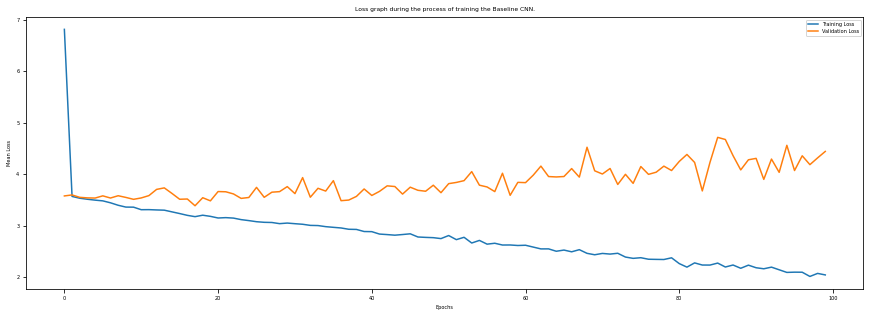

In [60]:
# plot the loss diagram
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='best')
plt.ylabel('Mean Loss')
plt.xlabel('Epochs')
plt.title(f"Loss graph during the process of training the Baseline CNN.")
plt.show()

Model has overfit. Likely because our data size is much smaller than what the paper used

In [61]:
# create test df
test_df = df[df['in_train']==False]
print(test_df.shape)
test_df.head()

(23817, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
7,Hiroshige,1838,bird-and-flower painting,6483.0,9276.0,12762418.0,wikiart,Ukiyo-e,Small Bird on a Branch of Kaidozakura,train_and_test,False,49823.jpg
9,Franz Richard Unterberger,NaN,cityscape,6238.0,7352.0,7896792.0,wikiart,Romanticism,Procession in Naples,train_and_test,False,84512.jpg


In [62]:
# only using those artists that model was trained on
artists = list(y_rus.unique())
test_df = test_df[test_df['artist'].isin(artists)]

In [63]:
print(test_df.shape)
test_df.head()

(3984, 12)


,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
34,Gustave Dore,NaN,illustration,5878.0,4678.0,24158097.0,wikiart,Romanticism,The hoarders and wasters,train_and_test,False,31977.jpg
279,Pierre-Auguste Renoir,1917,sketch and study,4476.0,3396.0,8423735.0,wikiart,Impressionism,Sitting Girl,train_and_test,False,85018.jpg
325,Rembrandt,1669,self-portrait,3415.0,4224.0,3760367.0,wikiart,Baroque,Self-portrait in at the Age of 63,train_and_test,False,68576.jpg
400,Alfred Sisley,1885,landscape,4476.0,3042.0,7207696.0,wikiart,Impressionism,The banks of the Loing Moret,train_and_test,False,22289.jpg
451,Rembrandt,1640,portrait,3268.0,4045.0,4222317.0,wikiart,Baroque,Self-portrait at the Age of 34,train_and_test,False,67638.jpg


In [64]:
# taking a smaller stratified subset of test_df
test_df['artist'].value_counts()

Marc Chagall                  133
Ivan Shishkin                 133
Isaac Levitan                 128
Nicholas Roerich              127
Paul Gauguin                  125
Rembrandt                     124
Zdislav Beksinski             124
Pablo Picasso                 123
John Singer Sargent           123
James Tissot                  123
Ivan Aivazovsky               122
Childe Hassam                 118
Albrecht Durer                117
Claude Monet                  115
Gustave Dore                  113
Pierre-Auguste Renoir         112
Pyotr Konchalovsky            111
Henri Matisse                 111
Henri Martin                  110
Boris Kustodiev               110
Eugene Boudin                 109
Edgar Degas                   108
Zinaida Serebriakova          108
Alfred Sisley                 108
Camille Pissarro              106
Ilya Repin                    103
Vincent van Gogh              102
Camille Corot                 101
Martiros Saryan               100
Giovanni Batti

__randomly sample 30 artworks of each artist__

In [65]:
test_sub = test_df.groupby('artist', group_keys=False).apply(lambda x: x.sample(30, random_state = 42))

In [66]:
print(test_sub.shape)
test_sub['artist'].value_counts()

(1080, 12)


Albrecht Durer                30
Alfred Sisley                 30
James Tissot                  30
John Singer Sargent           30
Marc Chagall                  30
Martiros Saryan               30
Nicholas Roerich              30
Odilon Redon                  30
Pablo Picasso                 30
Paul Cezanne                  30
Paul Gauguin                  30
Pierre-Auguste Renoir         30
Pyotr Konchalovsky            30
Rembrandt                     30
Theophile Steinlen            30
Vincent van Gogh              30
Zdislav Beksinski             30
Ivan Shishkin                 30
Ivan Aivazovsky               30
Isaac Levitan                 30
Ernst Ludwig Kirchner         30
Boris Kustodiev               30
Camille Corot                 30
Camille Pissarro              30
Childe Hassam                 30
Claude Monet                  30
Edgar Degas                   30
Eugene Boudin                 30
Ilya Repin                    30
Fernand Leger                 30
Giovanni B

In [67]:
# resize test images
# directory = 'test'

# for filename in os.listdir(directory):
#     try:
#         if filename.endswith('.jpg'):
#             img_path = os.path.join(directory, filename)
#             with Image.open(img_path) as img:
#                 img_resized = img.resize((256, 256), resample=Image.BILINEAR)
#                 img_resized.convert('RGB').save(os.path.join(directory, filename))
#     except:
#         print(f"Could not process image {filename}")

In [68]:
# corrupted files
test_sub[test_sub['new_filename'].isin(['20153.jpg','9989.jpg','100532.jpg','18649.jpg','24000.jpg'])]

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename


(256, 256)


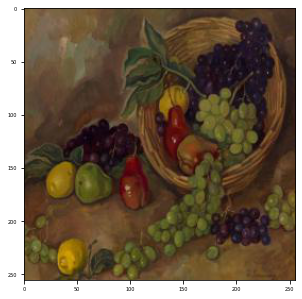

In [69]:
filename = test_sub.loc[39942]['new_filename'] 
img = Image.open(os.path.join('test', filename))
plt.imshow(img)
print(img.size)  # Should print (256, 256)

In [70]:
test_art = test_sub['artist'].unique()

In [71]:
le_test = preprocessing.LabelEncoder()
le_test.fit(test_art)
le_test.classes_

array(['Albrecht Durer', 'Alfred Sisley', 'Boris Kustodiev',
       'Camille Corot', 'Camille Pissarro', 'Childe Hassam',
       'Claude Monet', 'Edgar Degas', 'Ernst Ludwig Kirchner',
       'Eugene Boudin', 'Fernand Leger', 'Giovanni Battista Piranesi',
       'Gustave Dore', 'Henri Martin', 'Henri Matisse',
       'Henri de Toulouse-Lautrec', 'Ilya Repin', 'Isaac Levitan',
       'Ivan Aivazovsky', 'Ivan Shishkin', 'James Tissot',
       'John Singer Sargent', 'Marc Chagall', 'Martiros Saryan',
       'Nicholas Roerich', 'Odilon Redon', 'Pablo Picasso',
       'Paul Cezanne', 'Paul Gauguin', 'Pierre-Auguste Renoir',
       'Pyotr Konchalovsky', 'Rembrandt', 'Theophile Steinlen',
       'Vincent van Gogh', 'Zdislav Beksinski', 'Zinaida Serebriakova'],
      dtype=object)

In [72]:
# create dataloaders, batch size etc
class TestDataset(Dataset):
    def __init__(self,img_dir, dataframe, transformation): 
        self.transformation = transform
       
        self.encoder = le_test
        self.img_dir = img_dir
        self.feats, self.labels = self.get_all(self.img_dir,dataframe)
        
    def get_all(self,img_dir,dataframe):
        images = []
        labels = []
        
        for index, row in dataframe.iterrows():
            file = row['new_filename']
            img = Image.open(os.path.join(img_dir, file)) 
            data = self.transformation(img)
            images.append(data)
            
            artist = row['artist']
            label = self.encoder.transform([artist])[0]
            labels.append(label)
        
        #labels = self.encoder.transform(y)
        
        images = torch.stack(images)
        labels = torch.LongTensor(labels)
        return images, labels
            
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,item):
        return self.feats[item], self.labels[item]

In [ ]:
#testset = TestDataset('test',test_sub,transform)

In [73]:
#torch.save(testset,'testset.pt')
testset = torch.load('testset.pt')

In [74]:
test_loader = DataLoader(testset, batch_size=batch_size ,drop_last=True, shuffle=True)

In [76]:
# evaluate on test set
def evaluate(model, test_dataloader, device=device):
    model.eval()
    predictions = []
    ground = []
#     total_correct = 0
#     total_samples = 0
    
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs,labels = data
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            
            output_idx = torch.argmax(output,dim=1)
            
            predictions.append(output_idx.numpy())
            ground.append(labels.numpy())
            
#             _, predicted = torch.max(output.data, 1)
#             total_correct += (predicted == labels).sum().item()
#             total_samples += labels.size(0)
            
#     accuracy = 100 * (total_correct / total_samples)
#     print(f'Test Accuracy: {accuracy:.2f}%')
    
    return predictions, ground

In [77]:
model = CNNBase()
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [78]:
pred, ground = evaluate(model,test_loader)
y_true = np.concatenate(ground, axis=0)
y_pred = np.concatenate(pred, axis=0)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [81]:
len(y_true), len(y_pred)

(1056, 1056)

In [80]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.43      0.13        30
           1       0.11      0.03      0.05        29
           2       0.00      0.00      0.00        30
           3       0.33      0.07      0.12        28
           4       0.10      0.03      0.05        29
           5       0.00      0.00      0.00        29
           6       0.33      0.07      0.11        29
           7       0.00      0.00      0.00        30
           8       0.18      0.21      0.19        29
           9       0.12      0.21      0.15        29
          10       0.00      0.00      0.00        30
          11       0.19      0.41      0.26        29
          12       0.40      0.27      0.32        30
          13       0.14      0.04      0.06        28
          14       0.33      0.07      0.11        29
          15       0.00      0.00      0.00        29
          16       0.00      0.00      0.00        28
          17       0.00    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


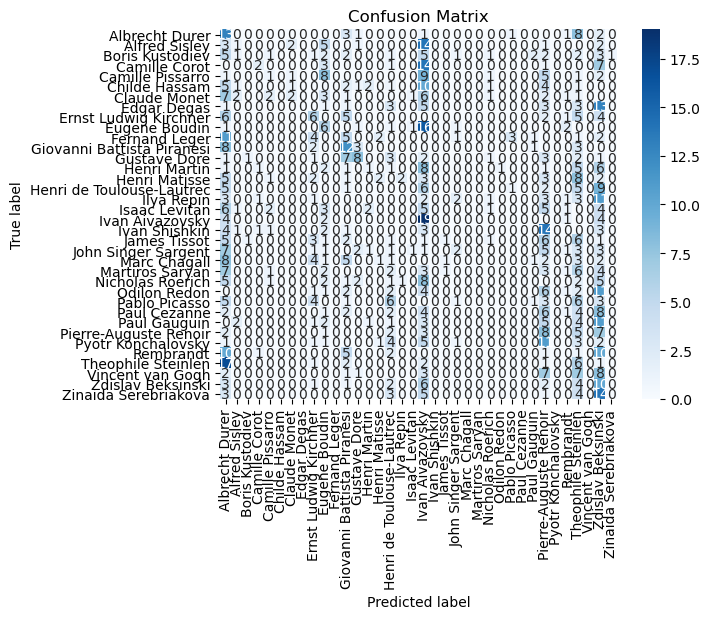

In [82]:
matplotlib.rc_file_defaults() # to remove the sns darkgrid style
cm = confusion_matrix(y_true, y_pred)
classes = list(le.classes_)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

#### Testing Accuracy: 9%

## ResNet

In [83]:
from torchvision import models

In [89]:
rn18 = models.resnet18(pretrained=True)

In [90]:
num_classes = len(le.classes_)
num_classes

36

In [91]:
# modify last layer
rn18.fc = nn.Sequential(
    nn.Linear(rn18.fc.in_features, num_classes),
    nn.Softmax(dim=1)) # can remove softmax?


In [92]:
# Freeze the model
for param in rn18.parameters():
    param.requires_grad = False
for param in rn18.fc.parameters():
    param.requires_grad = True

In [93]:
# Train the model- only the last layer
optimizer = optim.Adam(rn18.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss_rn18 = []
val_loss_rn18 = []
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
rn18_path = 'best_rn18.pt'

for epoch in range(10):
    rn18.train()
    batch_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs,labels = data
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        optimizer.zero_grad()
        
        # forward step
        outputs = rn18(inputs)
        loss = criterion(outputs,labels)
        
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        batch_loss.append(loss.data.item())
        
    train_loss = np.mean(batch_loss)
    train_loss_rn18.append(train_loss)
    
    rn18.eval()
    batch_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs,labels = data
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # forward step
            outputs = rn18(inputs)
            loss = criterion(outputs,labels)

            batch_loss.append(loss.data.item())
            
        val_loss = np.mean(batch_loss)
        val_loss_rn18.append(val_loss)
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(rn18.state_dict(), rn18_path)
    else:
        early_stop_counter+=1 
        if early_stop_counter >= patience:
            print("Early stopping: validation loss has not improved in {} epochs".format(patience))
            break
    #if epoch%10==0:
    print(f"[{epoch+1}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")
        

In [ ]:
#torch.save(rn18.state_dict(), 'latest_rn18.pt')

In [85]:
train_loss_rn18 = read_list('train_losses_rn18')
val_loss_rn18 = read_list('val_loss_rn18')

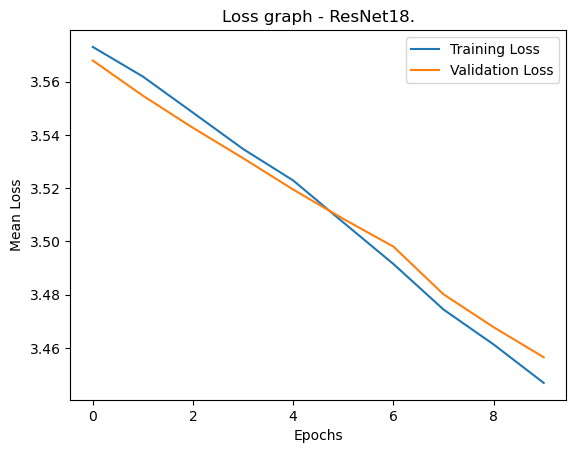

In [86]:
# plot the loss diagram
plt.plot(train_loss_rn18,label='Training Loss')
plt.plot(val_loss_rn18, label='Validation Loss')
plt.legend(loc='best')
plt.ylabel('Mean Loss')
plt.xlabel('Epochs')
plt.title(f"Loss graph - ResNet18.")
plt.show()

In [87]:
# write_list(train_loss_rn18,'train_losses_rn18')
# write_list(val_loss_rn18,'val_loss_rn18')

In [94]:
model_rn18 = rn18
model_rn18.load_state_dict(torch.load('best_rn18.pt'))

<All keys matched successfully>

In [95]:
# pred, ground = evaluate(model_rn18,test_loader)
# y_true_rn18 = np.concatenate(ground, axis=0)
# y_pred_rn18 = np.concatenate(pred, axis=0)

In [99]:
# write_list(y_true_rn18,'y_true_rn18')
# write_list(y_pred_rn18,'y_pred_rn18')

Done writing list into a binary file
Done writing list into a binary file


In [96]:
y_true_rn18

array([26,  9,  3, ...,  5, 20, 21])

In [97]:
y_pred_rn18

array([15,  1,  1, ..., 13, 20, 29])

In [98]:
print(classification_report(y_true_rn18, y_pred_rn18))

              precision    recall  f1-score   support

           0       0.31      0.43      0.36        30
           1       0.15      0.55      0.24        29
           2       0.00      0.00      0.00        29
           3       0.60      0.10      0.18        29
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        30
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00        30
          10       0.25      0.90      0.39        30
          11       0.37      0.77      0.50        30
          12       0.33      0.87      0.48        30
          13       0.26      0.72      0.39        29
          14       0.00      0.00      0.00        29
          15       0.22      0.28      0.24        29
          16       0.22      0.50      0.31        30
          17       0.00    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


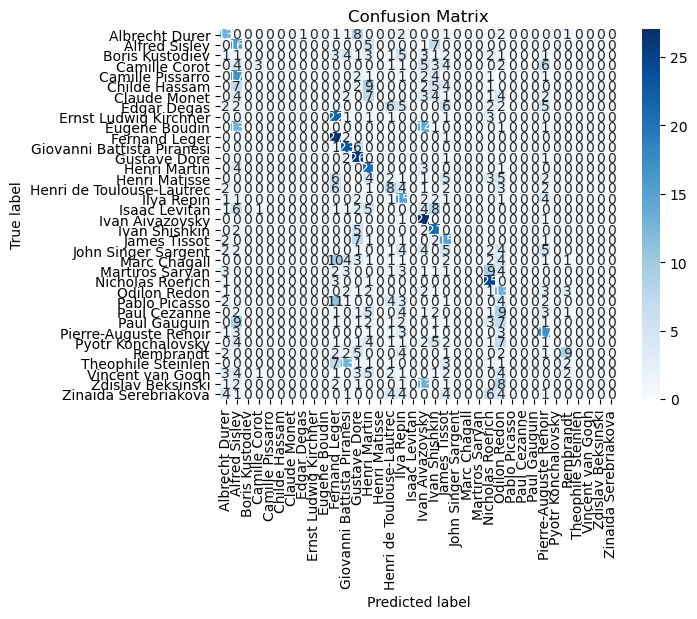

In [100]:
matplotlib.rc_file_defaults() # to remove the sns darkgrid style
cm = confusion_matrix(y_true_rn18, y_pred_rn18)
classes = list(le.classes_)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

#### Testing accuracy = 26%

## Updated ResNet
__Increasing number of Epochs to 20, increasing learning rate to 0.001__

In [101]:
rn18v1 = models.resnet18(pretrained=True)
num_classes = len(le.classes_)
# modify last layer
rn18v1.fc = nn.Sequential(
    nn.Linear(rn18v1.fc.in_features, num_classes),
    nn.Softmax(dim=1)) # can remove softmax?
# Freeze the model
for param in rn18v1.parameters():
    param.requires_grad = False
for param in rn18v1.fc.parameters():
    param.requires_grad = True

In [102]:
# Train the model- only the last layer
optimizer = optim.Adam(rn18v1.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss_rn18v1 = []
val_loss_rn18v1 = []
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
rn18v1_path = 'best_rn18v1.pt'

for epoch in range(20):
    rn18v1.train()
    batch_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs,labels = data
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        optimizer.zero_grad()
        
        # forward step
        outputs = rn18v1(inputs)
        loss = criterion(outputs,labels)
        
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        batch_loss.append(loss.data.item())
        
    train_loss = np.mean(batch_loss)
    train_loss_rn18v1.append(train_loss)
    
    rn18v1.eval()
    batch_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs,labels = data
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # forward step
            outputs = rn18v1(inputs)
            loss = criterion(outputs,labels)

            batch_loss.append(loss.data.item())
            
        val_loss = np.mean(batch_loss)
        val_loss_rn18v1.append(val_loss)
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(rn18v1.state_dict(), rn18v1_path)
    else:
        early_stop_counter+=1 
        if early_stop_counter >= patience:
            print("Early stopping: validation loss has not improved in {} epochs".format(patience))
            break
    #if epoch%10==0:
    print(f"[{epoch+1}/{20}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")
        

In [ ]:
#torch.save(rn18v1.state_dict(), 'latest_rn18v1.pt')

In [103]:
train_loss_rn18v1 = read_list('train_losses_rn18v1')
val_loss_rn18v1 = read_list('val_loss_rn18v1')

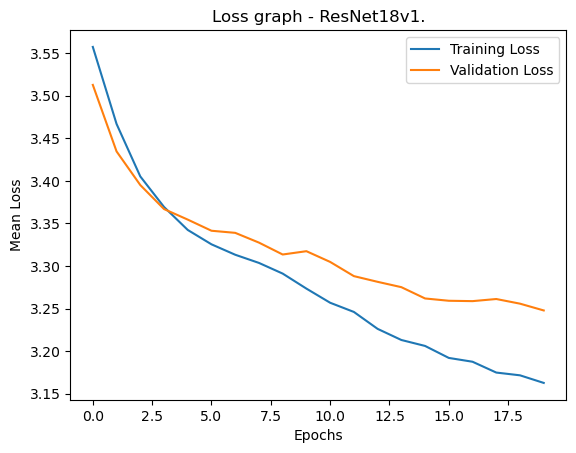

In [104]:
# plot the loss diagram
plt.plot(train_loss_rn18v1,label='Training Loss')
plt.plot(val_loss_rn18v1, label='Validation Loss')
plt.legend(loc='best')
plt.ylabel('Mean Loss')
plt.xlabel('Epochs')
plt.title(f"Loss graph - ResNet18v1.")
plt.show()

In [105]:
# write_list(train_loss_rn18v1,'train_losses_rn18v1')
# write_list(val_loss_rn18v1,'val_loss_rn18v1')

In [106]:
model_rn18v1 = rn18v1
model_rn18v1.load_state_dict(torch.load('best_rn18v1.pt'))

<All keys matched successfully>

In [107]:
# pred, ground = evaluate(model_rn18v1,test_loader)
# y_true_rn18v1 = np.concatenate(ground, axis=0)
# y_pred_rn18v1 = np.concatenate(pred, axis=0)

In [108]:
# write_list(y_true_rn18v1,'y_true_rn18v1')
# write_list(y_pred_rn18v1,'y_pred_rn18v1')

Done writing list into a binary file
Done writing list into a binary file


In [109]:
print(classification_report(y_true_rn18v1, y_pred_rn18v1))

              precision    recall  f1-score   support

           0       0.36      0.66      0.46        29
           1       0.36      0.70      0.48        30
           2       0.00      0.00      0.00        30
           3       0.44      0.63      0.52        30
           4       0.00      0.00      0.00        29
           5       0.20      0.55      0.30        29
           6       0.32      0.30      0.31        30
           7       0.38      0.67      0.49        30
           8       0.38      0.82      0.52        28
           9       0.45      0.83      0.58        30
          10       0.50      0.86      0.63        29
          11       0.59      0.93      0.72        29
          12       0.69      0.80      0.74        30
          13       0.00      0.00      0.00        30
          14       0.00      0.00      0.00        29
          15       0.00      0.00      0.00        29
          16       0.23      0.61      0.34        28
          17       0.32    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


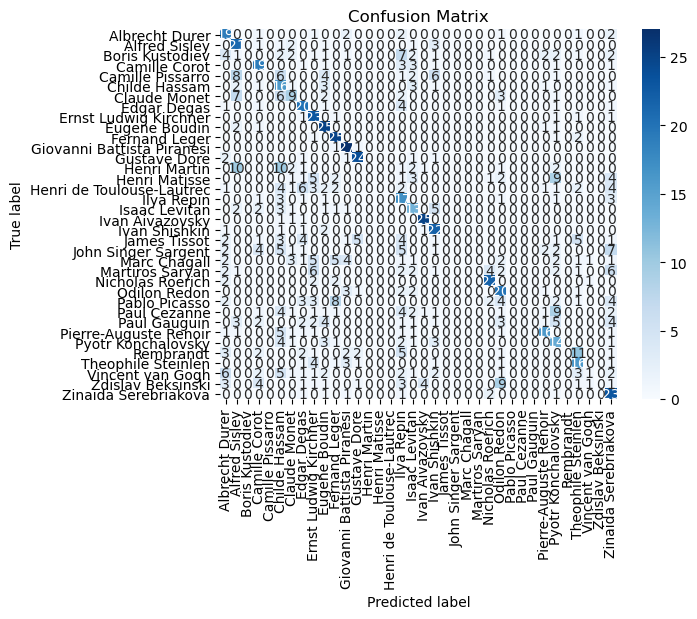

In [110]:
matplotlib.rc_file_defaults() # to remove the sns darkgrid style
cm = confusion_matrix(y_true_rn18v1, y_pred_rn18v1)
classes = list(le.classes_)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### Fine Tuning more layers of ResNet18

In [111]:
rn18v2 = models.resnet18(pretrained=True)
    
num_classes = len(le.classes_)
# modify last layer
rn18v2.fc = nn.Sequential(
    nn.Linear(rn18v2.fc.in_features, num_classes),
    nn.Softmax(dim=1)) # can remove softmax?


In [112]:
for name, child in rn18v2.named_children():
    if name in ['fc', 'layer4']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


In [113]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, rn18v2.parameters()), lr=0.001)

In [ ]:
train_loss_rn18v2 = []
val_loss_rn18v2 = []
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
rn18v2_path = 'best_rn18v2.pt'
epochs=20

for epoch in range(epochs):
    rn18v2.train()
    batch_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs,labels = data
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        optimizer.zero_grad()
        
        # forward step
        outputs = rn18v2(inputs)
        loss = criterion(outputs,labels)
        
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        batch_loss.append(loss.data.item())
        
    train_loss = np.mean(batch_loss)
    train_loss_rn18v2.append(train_loss)
    
    rn18v2.eval()
    batch_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs,labels = data
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # forward step
            outputs = rn18v2(inputs)
            loss = criterion(outputs,labels)

            batch_loss.append(loss.data.item())
            
        val_loss = np.mean(batch_loss)
        val_loss_rn18v2.append(val_loss)
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(rn18v2.state_dict(), rn18v2_path)
    else:
        early_stop_counter+=1 
        if early_stop_counter >= patience:
            print("Early stopping: validation loss has not improved in {} epochs".format(patience))
            break
    #if epoch%10==0:
    print(f"[{epoch+1}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")
        

In [ ]:
#torch.save(rn18v2.state_dict(), 'latest_rn18v2.pt')

In [114]:
train_loss_rn18v2 = read_list('train_losses_rn18v2')
val_loss_rn18v2 = read_list('val_loss_rn18v2')

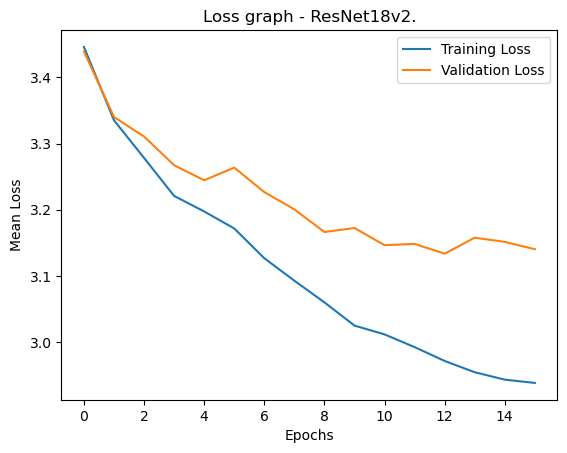

In [115]:
# plot the loss diagram
plt.plot(train_loss_rn18v2,label='Training Loss')
plt.plot(val_loss_rn18v2, label='Validation Loss')
plt.legend(loc='best')
plt.ylabel('Mean Loss')
plt.xlabel('Epochs')
plt.title(f"Loss graph - ResNet18v2.")
plt.show()

In [ ]:
# write_list(train_loss_rn18v2,'train_losses_rn18v2')
# write_list(val_loss_rn18v2,'val_loss_rn18v2')

In [116]:
model_rn18v2 = rn18v2
model_rn18v2.load_state_dict(torch.load('best_rn18v2.pt'))

<All keys matched successfully>

In [117]:
# pred, ground = evaluate(model_rn18v2,test_loader)
# y_true_rn18v2 = np.concatenate(ground, axis=0)
# y_pred_rn18v2 = np.concatenate(pred, axis=0)

In [118]:
# write_list(y_true_rn18v2,'y_true_rn18v2')
# write_list(y_pred_rn18v2,'y_pred_rn18v2')

Done writing list into a binary file
Done writing list into a binary file


In [119]:
print(classification_report(y_true_rn18v2, y_pred_rn18v2))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56        30
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        30
           5       0.55      0.53      0.54        30
           6       0.32      0.64      0.43        28
           7       0.59      0.55      0.57        29
           8       0.44      0.87      0.58        30
           9       0.66      0.86      0.75        29
          10       0.00      0.00      0.00        30
          11       0.75      1.00      0.86        30
          12       0.83      0.80      0.81        30
          13       0.73      0.80      0.76        30
          14       0.34      0.62      0.44        29
          15       0.26      0.63      0.37        30
          16       0.59      0.33      0.43        30
          17       0.29    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


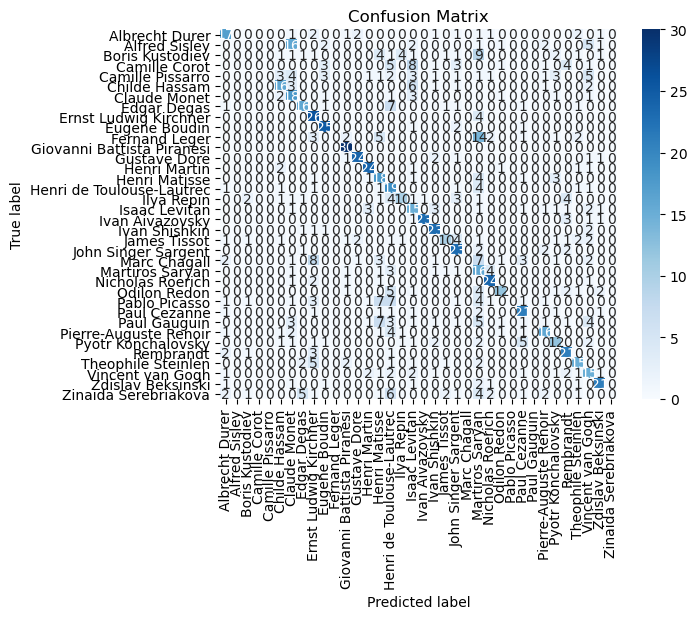

In [120]:
matplotlib.rc_file_defaults() # to remove the sns darkgrid style
cm = confusion_matrix(y_true_rn18v2, y_pred_rn18v2)
classes = list(le.classes_)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

#### Testing Accuracy 48%

__CNN: 9%__

__ResNet18 with 0.0001 learning rate and 10 epochs: 26%__

__ResNet18 with 0.001 learning rate and 20 epochs: 40%__

__ResNet18 with 0.001 learning rate and 20 epochs and fine tuning last two layers: 48%__

In [121]:
#!pip install --upgrade torchvision
from torchvision import models

In [122]:
rn50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/aditikumar/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [123]:

num_classes = len(le.classes_)
num_classes

36

In [124]:
# modify last layer
rn50.fc = nn.Sequential(
    nn.Linear(rn50.fc.in_features, num_classes),
    nn.Softmax(dim=1))

In [125]:
# Freeze the model
for param in rn50.parameters():
    param.requires_grad = False

for param in rn50.fc.parameters():
    param.requires_grad = True

In [126]:
# Train the model- only the last layer
optimizer = optim.Adam(rn50.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:

train_loss_rn50 = []
val_loss_rn50 = []
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
rn50_path = 'best_rn50.pt'

for epoch in range(20):
    rn50.train()
    batch_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = rn50(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.data.item())
        
    train_loss = np.mean(batch_loss)
    train_loss_rn50.append(train_loss)
    
    rn50.eval()
    batch_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = rn50(inputs)
            loss = criterion(outputs, labels)

            batch_loss.append(loss.data.item())

        val_loss = np.mean(batch_loss)
        val_loss_rn50.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(rn50.state_dict(), rn50_path)
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping: validation loss has not improved in {} epochs".format(patience))
            break

    print(f"[{epoch+1}/{10}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")

In [ ]:
#torch.save(rn50.state_dict(), 'latest_rn50.pt')

In [127]:
train_loss_rn50 = read_list('train_losses_rn50')
val_loss_rn50 = read_list('val_loss_rn50')

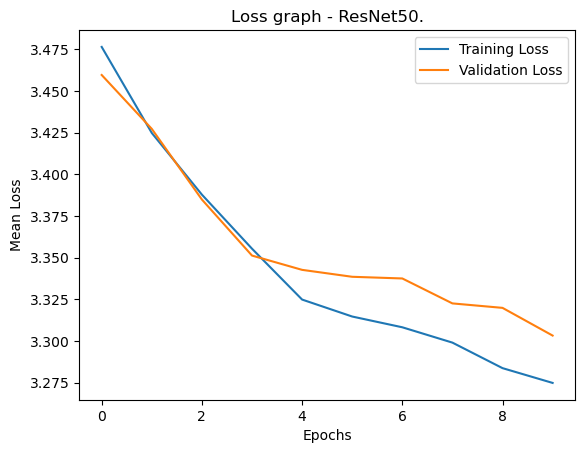

In [128]:
# plot the loss diagram
plt.plot(train_loss_rn50,label='Training Loss')
plt.plot(val_loss_rn50, label='Validation Loss')
plt.legend(loc='best')
plt.ylabel('Mean Loss')
plt.xlabel('Epochs')
plt.title(f"Loss graph - ResNet50.")
plt.show()

In [129]:
# write_list(train_loss_rn50,'train_losses_rn50')
# write_list(val_loss_rn50,'val_loss_rn50')

In [ ]:
model_rn50 = rn50
model_rn50.load_state_dict(torch.load('best_rn50.pt'))

In [ ]:
pred, ground = evaluate(model_rn50,test_loader)
y_true_rn50 = np.concatenate(ground, axis=0)
y_pred_rn50 = np.concatenate(pred, axis=0)

In [ ]:
write_list(y_true_rn50,'y_true_rn50')
write_list(y_pred_rn50,'y_pred_rn50')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
print(classification_report(y_true_rn50, y_pred_rn50, zero_division=1))

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true_rn50, y_pred_rn50)
accuracy

# Testing accuracy = 39%

resnet50 with 2p epochs, 00.001 lr and last 2 layers fine tuned 

In [131]:
from torchvision import models
rn50v1 = models.resnet50(pretrained=True)

In [132]:
num_classes = len(le.classes_)
num_classes 

36

In [133]:
rn50v1.fc = nn.Sequential(
    nn.Linear(rn50v1.fc.in_features, num_classes),
    nn.Softmax(dim=1))

In [134]:
for name, child in rn50v1.named_children():
    if name in ['layer3', 'layer4', 'fc']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, rn50v1.parameters()), lr=0.001)


In [ ]:
train_loss_rn50v1 = []
val_loss_rn50v1 = []
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
rn50v1_path = 'best_rn50v1.pt'

for epoch in range(20):
    rn50v1.train()
    batch_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = rn50v1(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.data.item())
        
    train_loss = np.mean(batch_loss)
    train_loss_rn50v1.append(train_loss)
    
    rn50v1.eval()
    batch_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = rn50v1(inputs)
            loss = criterion(outputs, labels)

            batch_loss.append(loss.data.item())

        val_loss = np.mean(batch_loss)
        val_loss_rn50v1.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(rn50v1.state_dict(), rn50v1_path)
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping: validation loss has not improved in {} epochs".format(patience))
            break

    print(f"[{epoch+1}/{20}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")
    

In [ ]:
#torch.save(rn50v1.state_dict(), 'latest_rn50v1.pt')

In [136]:
train_loss_rn50v1= read_list('train_losses_rn50v1')
val_loss_rn50v1 = read_list('val_loss_rn50v1')

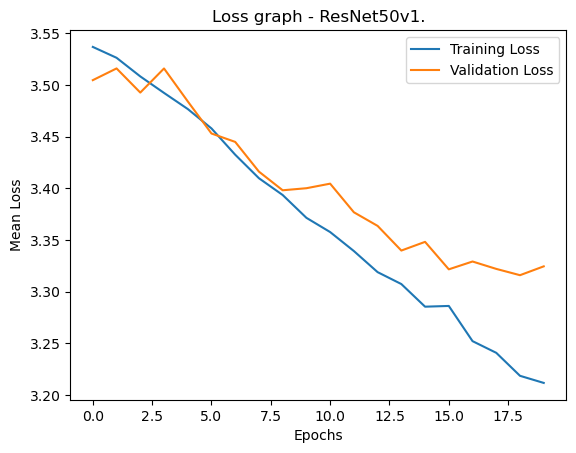

In [137]:
# plot the loss diagram
plt.plot(train_loss_rn50v1,label='Training Loss')
plt.plot(val_loss_rn50v1, label='Validation Loss')
plt.legend(loc='best')
plt.ylabel('Mean Loss')
plt.xlabel('Epochs')
plt.title(f"Loss graph - ResNet50v1.")
plt.show()

In [138]:
# write_list(train_loss_rn50v1,'train_losses_rn50v1')
# write_list(val_loss_rn50v1,'val_loss_rn50v1')

In [ ]:
model_rn50v1 = rn50v1
model_rn50v1.load_state_dict(torch.load('best_rn50v1.pt'))



In [ ]:
pred, ground = evaluate(model_rn50v1,test_loader)
y_true_rn50v1 = np.concatenate(ground, axis=0)
y_pred_rn50v1 = np.concatenate(pred, axis=0)

In [ ]:
y_true_rn50v1

In [ ]:
y_pred_rn50v1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib
print(classification_report(y_true_rn50v1, y_pred_rn50v1, zero_division=1))


In [ ]:
matplotlib.rc_file_defaults() # to remove the sns darkgrid style
cm = confusion_matrix(y_true_rn50v1, y_pred_rn50v1)
classes = list(le.classes_)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true_rn50v1, y_pred_rn50v1)
accuracy

### testing accuracy = 32%

# VGGNet with batch norm
fine tune last 3 layers, lr = 0.001, epochs = 10

In [130]:
vgg16 = torchvision.models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /Users/aditikumar/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [144]:
for name, child in vgg16.named_parameters():
    print(name)

features.0.weight
features.0.bias
features.1.weight
features.1.bias
features.3.weight
features.3.bias
features.4.weight
features.4.bias
features.7.weight
features.7.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
features.11.weight
features.11.bias
features.14.weight
features.14.bias
features.15.weight
features.15.bias
features.17.weight
features.17.bias
features.18.weight
features.18.bias
features.20.weight
features.20.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.25.weight
features.25.bias
features.27.weight
features.27.bias
features.28.weight
features.28.bias
features.30.weight
features.30.bias
features.31.weight
features.31.bias
features.34.weight
features.34.bias
features.35.weight
features.35.bias
features.37.weight
features.37.bias
features.38.weight
features.38.bias
features.40.weight
features.40.bias
features.41.weight
features.41.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [147]:
# Freeze weights of all layers except the last 3
for param in vgg16.parameters():
    param.requires_grad = False
for param in vgg16.features[-1].parameters():
    print(vgg16.features[-1])
    param.requires_grad = True
for param in vgg16.classifier[-1].parameters():
    print(vgg16.classifier[-1])
    param.requires_grad = True
for param in vgg16.classifier[-2].parameters():
    print(vgg16.classifier[-2])
    param.requires_grad = True

Linear(in_features=4096, out_features=1000, bias=True)
Linear(in_features=4096, out_features=1000, bias=True)


In [148]:
vgg16.classifier[-1] = nn.Linear(4096, num_classes)

In [149]:
vgg16.classifier[-1]

Linear(in_features=4096, out_features=36, bias=True)

In [150]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
train_loss_vgg16= []
val_loss_vgg16 = []
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
vgg16_path = 'best_vgg16.pt'

for epoch in range(10):
    vgg16.train()
    batch_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.data.item())
        
    train_loss = np.mean(batch_loss)
    train_loss_vgg16.append(train_loss)
    
    vgg16.eval()
    batch_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)

            batch_loss.append(loss.data.item())

        val_loss = np.mean(batch_loss)
        val_loss_vgg16.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(vgg16.state_dict(), vgg16_path)
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping: validation loss has not improved in {} epochs".format(patience))
            break

    print(f"[{epoch+1}/{10}] Training loss: {train_loss:.4f}\t Validation loss: {val_loss:.4f}.")